###  Libraries

In [ ]:
from __future__ import annotations

import pathlib
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import joblib

# Visuals / utils
from visualizations import (
    na_visualization,
    correlation_heatmap,
    plot_feature_importance,
    feature_importance_heatmap,
    plot_pca_variance,
)
from utils import detect_outliers_iqr, build_features, compute_feature_importance


##  Introspective view of the dataset 

In [ ]:
df=pd.read_csv('data\student-data.csv')
#
display(df.head(10))

In [ ]:
from visualizations import na_visualization 


print("\n*** BASIC INFORMATION ***\n")
display(df.info())
print("\nShape        :", df.shape)
print("\nNumeric cols :", df.select_dtypes("number").columns.tolist())
print("Categorical  :", df.select_dtypes("object").columns.tolist())
display(df.describe().transpose().style.background_gradient(cmap='Blues'))
# 1.2 Detección de outliers
outliers = detect_outliers_iqr(df.select_dtypes("number"))           
print(f"{len(outliers)} índices con posibles outliers")
na_visualization(df)


Hablar sobre la base de datos, comentar un poco no hace falta extederse demasiado



In [ ]:
from visualizations import class_distribution
from pywaffle import Waffle
import matplotlib.pyplot as plt  
import seaborn as sns  

class_distribution(df)

### **Choice of Class Encoding (pass = 0, fail = 1)**
Our label encoding was driven by the operational goal of the project rather than by convenience of the code. The assignment brief explicitly states that “the main goal … is to develop a machine-learning pipeline capable of predicting whether a given student will pass their final exam, thus allowing an intervention system that may flag individual students requiring extra attention and support EIACD_Assignment_2_2024…. In practice, those “individual students” are precisely the ones at risk of failing, so we marked failure as the positive class (1) and success as the negative class (0). This decision has three main advantages:

* **Metric focus on the target population.**
Precision, recall, F-score, and the area under the Precision-Recall curve are all computed with respect to the class coded as 1. By assigning fail = 1, these metrics now directly quantify the model’s ability to identify students who need help most urgently.

* **Interpretable probabilities for early-warning systems.**
The classifier’s predict_proba() now outputs P(fail) rather than P(pass). Dashboard thresholds can therefore be set on an intuitive “probability of failure” scale (e.g., intervene when risk ≥ 0.30).

* **Alignment with class imbalance techniques.**
As the exploratory visualisations show, the dataset is moderately imbalanced: ≈ 260 passes (67 %) vs 130 failures (33 %).
Figure 1 (waffle plot) highlights this skew, and Figure 2 (bar chart) annotates the exact counts.
Treating the minority (failures) as the positive class is standard practice when applying resampling strategies such as SMOTE or ADASYN that the rubric encourages; it maximises the effectiveness of these techniques on the group that matters.

**Why not the opposite mapping?**
Reversing the labels would leave overall accuracy and AUC unchanged, but it would push the minority class into the background of the evaluation, complicating threshold selection and diluting the pedagogical value of the metrics. Given that the primary objective is intervention, not mere forecasting, the chosen encoding provides clearer, action-oriented insights without affecting the mathematical correctness of the models.

In short, coding pass = 0 and fail = 1 turns every subsequent metric and probability into a direct measure of academic risk, fully supporting the intervention philosophy articulated in the project documentation.



# **EDA**

## Numerical Features


* **age** (integer): student’s age in years, ranging from 15 to 22.

* **Medu** (integer, ordinal): mother’s education level (0 = none, 1 = primary (4th grade), 2 = 5–9th grade, 3 = secondary, 4 = higher).
* **Fedu** (integer, ordinal): father’s education level (same coding as Medu).
* **famrel** (integer, ordinal): quality of family relationships, 1 (very bad) to 5 (excellent).
* **traveltime** (integer, ordinal): home-to-school travel time, 1 (< 15 min) to 4 (> 1 hour).
* **studytime** (integer, ordinal): weekly study time, 1 (< 2 hr) to 4 (> 10 hr).
* **failures** (integer): number of past class failures, coded as n if 1≤n<3, else 4 (i.e. ≥ 3 failures).
* **freetime** (integer, ordinal): free time after school, 1 (very low) to 5 (very high).
* **goout** (integer, ordinal): frequency of going out with friends, 1 (very low) to 5 (very high).
* **Walc** (integer, ordinal): weekend alcohol consumption, 1 (very low) to 5 (very high).
* **Dalc** (integer, ordinal): weekday alcohol consumption, 1 (very low) to 5 (very high).
* **health** (integer, ordinal): current health status, 1 (very bad) to 5 (very good).
* **absences** (integer): number of school absences, from 0 up to 93.




In [ ]:
from visualizations import numerical_features_visualization
num_cols = df.select_dtypes(include='number').columns.tolist()
numerical_features_visualization(df,num_cols,True)


**Cosas a mencionar del gráfico de arriba (se tiene que retocar )**


**Figure 1.** Univariate Histograms of Key Numerical Predictors

**Figure 2.** Pairwise distributions and kernel density estimates (diagonal) alongside bivariate scatterplots (off‐diagonal) for key continuous predictors stratified by final exam outcome (“passed” vs. “not passed”).



### Diagonal Panels (Univariate Densities)

Each variable’s marginal distribution is overlaid for students who passed (green) and those who did not (salmon). Notable observations include:

* **Age:** Both groups concentrate between 16–18 years, though the density for non‐passers exhibits a modest rightward skew, suggesting slightly older students are at increased risk of failure.
* **Parental Education (Medu, Fedu):** Pass‐rate density peaks at parental education levels 3–4; by contrast, non‐passers accumulate at levels 1–2, implying a positive association between parental schooling and student success.
* **Travel Time:** Passers predominantly report travel times ≤ 2, whereas non‐passers show appreciable density at 3–4, indicating that lengthy commutes may adversely affect performance.
* **Study Time:** A clear separation emerges: densities for successful students rise markedly at ≥ 2 hours of weekly study, whereas non‐passers cluster below that threshold.
* **Failures:** The vast majority of students without prior failures pass the final (density spike at 0), while densities for one or more past failures shift toward non‐passers.
* **Alcohol Consumption & Social Life (Dalc, Walc, goout):** Non‐passers concentrate at high daily/weekly alcohol use and frequent social outings (levels 4–5), in contrast to passers who are denser at lower levels.
* **Family Relations & Health:** Though these factors display more overlap, passers show a modest density advantage at higher family‐relation and health ratings.
* **Absences:** A long‐tailed distribution emerges: passers cluster tightly below ten absences, whereas non‐passers populate the upper tail, corroborating absenteeism as a risk factor.



### Off-Diagonal Panels (Bivariate Relations)

Scatterplots reveal joint patterns that reinforce univariate findings and suggest interactions:

* **Study Time vs. Failures:** A negative relationship appears: increased study time coincides with fewer past failures, and the green points dominate the high‐study/low‐failures region.
* **Absences vs. Travel Time:** Students with longer commutes tend to accrue more absences; these points are disproportionately salmon, emphasizing the compound effect of travel burden and absenteeism.
* **Alcohol Use vs. Social Activity:** High daily/weekly alcohol consumption combined with frequent outings forms a distinct cluster of non‐passers, underscoring lifestyle factors.
* **Parental Education vs. Failures:** Lower parental education correlates with greater past failures and a higher density of non-passers, while higher Medu/Fedu aligns with student success.
* **Family Relations vs. Health:** Although the correlation is weak, passers are more prevalent in the quadrant of both high family‐relation scores and good health, suggesting a supportive home environment may bolster outcomes.


### Implications for Intervention

These density and scatter patterns collectively identify **protective factors**—low absenteeism, short commute, sufficient study time, absence of prior failures, low alcohol/social distractions, and higher parental education—as well as **risk factors** that can inform early warning systems. The clear separation of passers and non-passers along these dimensions validates their inclusion in a predictive model and guides targeted support strategies (e.g., commuter assistance, study‐skills workshops, and family engagement interventions).


## Categorical Features  

* **sex** (binary nominal): {“F” = female, “M” = male}.

* **school** (binary nominal): {“GP” = Gabriel Pereira, “MS” = Mousinho da Silveira}.
* **address** (binary nominal): {“U” = urban, “R” = rural}.
* **Pstatus** (binary nominal): parents’ cohabitation status {“T” = together, “A” = apart}.
* **Mjob** (nominal): mother’s job category {“teacher”, “healthcare”, “civil services”, “at\_home”, “other”}.
* **Fjob** (nominal): father’s job (same categories as Mjob).
* **guardian** (nominal): primary guardian {“mother”, “father”, “other”}.
* **famsize** (binary nominal): family size {“LE3” = ≤ 3, “GT3” = > 3}.
* **reason** (nominal): reason to choose this school {“home”, “reputation”, “course”, “other”}.
* **schoolsup** (binary nominal): extra educational school support {“yes”, “no”}.
* **famsup** (binary nominal): family educational support {“yes”, “no”}.
* **activities** (binary nominal): extra-curricular activities {“yes”, “no”}.
* **paidclass** (binary nominal): extra paid classes {“yes”, “no”}.
* **internet** (binary nominal): Internet access at home {“yes”, “no”}.
* **nursery** (binary nominal): attended nursery school {“yes”, “no”}.
* **higher** (binary nominal): wants to take higher education {“yes”, “no”}.
* **romantic** (binary nominal): in a romantic relationship {“yes”, “no”}.&#x20;


In [ ]:
from visualizations import categorical_visualization

categorical_visualization(df)


**Figure 3 Cramér’s V for Categorical Predictors vs. Final-Exam Outcome**  
_Cramér’s V_ is a normalized measure of association between two nominal (categorical) variables, derived from the χ² statistic. It ranges from 0 (no association) to 1 (perfect association), making it ideal for comparing the predictive relevance of multiple categorical features against a binary target.

| Predictor                  | Cramér’s V |
|----------------------------|:----------:|
| **higher**                 |   0.15     |
| **guardian**               |   0.12     |
| **Mjob**                   |   0.12     |
| **reason**                 |   0.11     |
| **romantic**               |   0.10     |
| **schoolsup**              |   0.09     |
| **paid**                   |   0.08     |
| **Fjob**                   |   0.08     |
| **sex**                    |   0.07     |
| **internet**               |   0.07     |
| **famsup**                 |   0.05     |
| **address**                |   0.05     |
| **famsize**                |   0.05     |
| **Pstatus**                |   0.04     |
| **school**                 |   0.04     |
| **activities**             |   0.02     |
| **nursery**                |   0.01     |

Key observations:

- **Strongest Associations**  
  - *higher* (V≈0.15): Students who plan to pursue higher education are most strongly differentiated between pass/fail outcomes.  
  - *guardian*, *Mjob* (V≈0.12): The identity of the primary guardian and the mother’s occupation also show relatively high linkage to exam success.

- **Moderate Associations**  
  - *reason*, *romantic*, *schoolsup* (V≈0.09–0.11): School-choice rationale, romantic involvement, and receipt of extra academic support exhibit intermediate predictive value.

- **Weak or Negligible Associations**  
  - *activities*, *nursery* (V<0.03): Participation in extracurricular activities and nursery attendance contribute little to distinguishing pass vs. fail.

These results provide a principled basis for **feature selection**, highlighting socio-demographic variables that are most likely to enhance classification performance in subsequent predictive modeling.```


# **Preprocessing** 

### Train/Test Split 

In [ ]:
df['passed']=df['passed'].map({"no":1,"yes":0})
X = df.drop(columns=["passed"])
y = df["passed"]


numeric_cols = X.select_dtypes("number").columns.tolist()
categorical_cols = X.select_dtypes("object").columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("\nSize of Train set      :", X_train.shape)
print("Size of Test set       :", X_test.shape)



Cosas a mencionar  : 

No haremos imputacion debido a que no hay ningun NA ni valor faltante 

## Encoding Strategies
1. One-Hot Encoding for Nominals
To avoid imposing spurious ordinal relationships, each category in the three nominal attributes was expanded into independent indicator variables. This yields a sparse, non-hierarchical representation suitable for distance-based or linear classifiers without biasing one level over another.

2. Ordinal Encoding for Ranked Scales
Each ordinal feature (e.g., education levels from 0–4; scales from 1–5) was mapped to its integer rank. This approach preserves monotonic relationships—critical when modelling assumptions exploit increasing or decreasing trends—while avoiding an explosion of dimensions.

3. Binary Mapping for Dichotomous Variables
All yes/no or two-category fields were converted directly into {0, 1}. For example, “yes”→1 and “no”→0, “GP”→0 and “MS”→1, etc. This compact mapping reduces dimensionality and maintains interpretability.

4. Standard Scaling for Continuous Variables
Student age and absence count were standardized to zero mean and unit variance. This normalization mitigates the risk that numerical magnitudes dominate model training and facilitates convergence for gradient-based algorithms.

In [ ]:
from utils import detect_outliers_iqr
from importlib import reload
import visualizations
reload(visualizations)

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

# Mapeo genérico para todas las binarias
def map_binaries(df):
    return df.replace({
        'school':   {'GP':0, 'MS':1},
        'sex':      {'F':0, 'M':1},
        'address':  {'U':1, 'R':0},
        'famsize':  {'LE3':0,'GT3':1},
        'Pstatus':  {'T':1, 'A':0},
        'schoolsup':{'yes':1,'no':0},
        'famsup':   {'yes':1,'no':0},
        'paid':     {'yes':1,'no':0},
        'activities':{'yes':1,'no':0},
        'nursery':  {'yes':1,'no':0},
        'internet': {'yes':1,'no':0},
        'romantic': {'yes':1,'no':0},
        'higher'  : {'yes':1,'no':0},
    })
ord_feats = ['Medu','Fedu','famrel','freetime','goout','Dalc','Walc','health','studytime','traveltime','failures']
bin_feats = ['school','sex','address','famsize','Pstatus','schoolsup','famsup','paid','activities','nursery','internet','romantic','higher']
preprocessor = ColumnTransformer([
    # 1. One-hot para ocupaciones y guardian (dense output)
    ('jobs', OneHotEncoder(sparse_output=False), ['Mjob','Fjob','guardian','reason']),
    # 2. Ordinal para niveles y escalas 1–5
    ('ordinal', OrdinalEncoder(), ord_feats),
    # 3. Función de mapeo para todas las binarias
    ('binary', Pipeline([
        ('mapper', FunctionTransformer(map_binaries, validate=False))
    ]), bin_feats),
], remainder='drop')

# Ajuste y transformación
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# Reconstrucción de DataFrame con nombres de columna
ohe = preprocessor.named_transformers_['jobs']
ohe_feats = ohe.get_feature_names_out(['Mjob','Fjob','guardian','reason']).tolist()

# num_feats = ['age','absences']

# afeature_names = preprocessor.get_feature_names_out()
all_feature_names = ohe_feats + ord_feats + bin_feats

X_train_sinnum = pd.DataFrame(X_train_proc, columns=all_feature_names, index=X_train.index)
X_test_sinnum   = pd.DataFrame(X_test_proc, columns=all_feature_names, index=X_test.index)

X_train = pd.concat([X_train_sinnum, X_train[['age','absences']]], axis=1)
X_test = pd.concat([X_test_sinnum, X_test[['age','absences']]], axis=1)
display(X_train) 
print("Dimensions :", X_train.shape)
correlation_heatmap(X_train)




##  Correlation 


In the exploratory analysis of the preprocessed student dataset, we examined the Pearson correlation matrix among 37 features—after one-hot encoding of categorical variables—and filtered out trivial correlations arising solely from complementary dummy variables (e.g., between different levels of the same original category). We identified seven non-obvious associations with absolute correlation coefficients |ρ| ≥ 0.35 that may yield pedagogical or behavioral insights and thus merit discussion in the final report.

| Pair of Features                                              |      ρ | Interpretation                                                                                                                                                               |
| ------------------------------------------------------------- | -----: | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Dalc** (weekday alcohol) ↔ **Walc** (weekend alcohol)       |  0.637 | Students who consume more alcohol on weekdays also tend to drink heavily on weekends, indicating a generalized pattern of risk behavior rather than isolated episodes.       |
| **Medu** (mother’s education) ↔ **Fedu** (father’s education) |  0.621 | Strong educational homogamy in the parental couple suggests that children in households with two highly educated parents may benefit from compounded academic support.       |
| **Mjob\_teacher** ↔ **Medu**                                  |  0.491 | Mothers employed as teachers have, unsurprisingly, higher formal education; this quantifies why “mother-is-teacher” could serve as a proxy for parental educational capital. |
| **goout** (socializing) ↔ **Walc**                            |  0.469 | A more active social life correlates with increased weekend drinking, linking leisure patterns to potential impacts on study time and academic outcomes.                     |
| **Mjob\_at\_home** ↔ **Medu**                                 | –0.412 | Stay-at-home mothers tend to have lower formal education, complementing the previous finding and highlighting heterogeneous family environments.                             |
| **guardian\_other** ↔ **age**                                 |  0.386 | Older students more frequently report guardians other than mother or father (e.g., grandparents or themselves), suggesting shifts in living arrangements with age.           |
| **school** (GP vs MS) ↔ **age**                               |  0.363 | One of the two schools consistently enrolls slightly older students, possibly reflecting different admission cut-offs or retention policies.                                 |


## Feature Engineering

After the initial cleaning and preprocessing of the UCI student dataset, we construct nine derived variables to capture latent aspects of student behavior, social engagement, support structures, health risk, and commuting burdens. Table 1 summarizes each new feature, its motivation, and its mathematical definition.

### 1. Leisure–Study Balance

To gauge whether students allocate more time to leisure or to academics, we compute

$$
leisure\_balance = freetime - studytime.
$$

Positive values indicate a student who enjoys ample free time relative to study demands, whereas negative values flag those investing heavily in study at the possible expense of rest or recreation.

### 2. Sociality Index

Peer interaction and extracurricular involvement often influence motivation and well-being. We sum four binary/numeric social indicators:

$$
sociality\_index = goout + romantic + activities + nursery.
$$

Higher scores denote more socially active students across friendships, relationships, after-school clubs, and early childhood group experiences.

### 3. Alcohol Consumption Index

Recognizing that weekend and weekday drinking carry different patterns, we weight them to form a single index:

$$
alcohol\_index = 0.4\cdot Dalc + 0.6\cdot Walc.
$$

This gives greater emphasis to weekend consumption (Walc), which tends to be more variable and potentially risk-bearing.

### 4. Health Risk Score

To approximate combined effects of self-reported health status and alcohol use, we define

$$
health\_risk\_score = (6 - health)\times alcohol\_index.
$$

Here, poorer health (lower health values) increases the multiplier, thus elevating the risk score for students who both report low health and higher alcohol use.

### 5. Digital Access

Access to online resources can support learning outside of class. We capture this by

$$
tech\_access = internet + address,
$$

where `internet` indicates home connectivity and `address` reflects an urban (1) vs. rural (0) residence.

### 6. Total Formal Support

Students may receive academic help from various sources. We aggregate three binary supports—school tutoring, family help, and paid classes—to get

$$
support\_sum = schoolsup + famsup + paid.
$$

This sum (0–3) reflects the breadth of formal educational assistance.

### 7. Support Mismatch

To detect potential discord between institutional vs. familial backing, we compute

$$
support\_mismatch = schoolsup - famsup.
$$

Values of +1 or –1 indicate support present in only one domain, whereas 0 signals consistent support levels.

### 8. Absence Ratio (Adjusted by Commute)

Long travel times may exacerbate absenteeism. We normalize absences by commute duration (plus one to avoid division by zero):

$$
absence\_ratio = \frac{absences}{traveltime + 1}.
$$

This “per-unit-commute” absence measure highlights students whose absences are disproportionately high given their travel burden.

### 9. Long Commuter Flag

Finally, we create a binary indicator for particularly lengthy commutes (≥ 3 on the original 1–4 scale, corresponding to ≥ 30 minutes):

$$
long\_commuter\_flag = 
\begin{cases}
1 & \text{if } traveltime \ge 3,\\
0 & \text{otherwise.}
\end{cases}
$$

This flag can be used to isolate students whose travel demands might impact attendance or study patterns.



In [ ]:
import utils
reload(utils)
from utils import build_features


X_train = build_features(X_train)
X_test = build_features(X_test)

feature_cols = [
    'leisure_balance', 'sociality_index', 'alcohol_index',
    'health_risk_score', 'tech_access', 'support_sum',
    'support_mismatch', 'absence_ratio', 'long_commuter_flag'
]

numerical_features_visualization(X_train,feature_cols,False)

##  Scaling 

In [ ]:
from sklearn.preprocessing import StandardScaler

# 1. Inicializas y ajustas el scaler con train
ToScale = [
    'age','absences',
    'leisure_balance','sociality_index','alcohol_index',
    'health_risk_score','tech_access','support_sum',
    'support_mismatch','absence_ratio'
]


scaler = StandardScaler()
scaler.fit(X_train[ToScale])


X_train[ToScale] = scaler.transform(X_train[ToScale])
X_test[ToScale]  = scaler.transform(X_test[ToScale])

## Feature Importance 

In [ ]:
from visualizations import feature_importance_heatmap
importance_df,_ = compute_feature_importance(X_train, y_train)


plot_feature_importance(importance_df, top_n=20)

importance_sorted = importance_df.sort_values('importance', ascending=False).reset_index(drop=True)
importance_sorted['rank'] = importance_sorted.index + 1

# List of newly engineered features
new_features = [
    'leisure_balance',
    'sociality_index',
    'alcohol_index',
    'health_risk_score',
    'tech_access',
    'support_sum',
    'support_mismatch',
    'absence_ratio',
    'long_commuter_flag'
]

# Filter and display name, importance, and ranking for new features
print('Importance position of the new features created by Feature Engineering ')
result = (
    importance_sorted
    .loc[importance_sorted['feature'].isin(new_features), ['rank', 'feature', 'importance']]
    .sort_values('rank',ascending=False)
)
display(result)
feature_importance_heatmap(importance_df)


# Baseline models

In [ ]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

model_params = {
    "logreg": {
        "model": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42),
        "params": {"C": [0.01, 0.1, 1, 10]},
    },
    "ridge": {
        "model": RidgeClassifier(class_weight="balanced", random_state=42),
        "params": {"alpha": [0.1, 1.0, 10.0]},
    },
    "rf": {
        "model": RandomForestClassifier(class_weight="balanced", random_state=42),
        "params": {"n_estimators": [200, 400], "max_depth": [None, 10, 20]},
    },
    "gb": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1], "max_depth": [3, 5]},
    },
    "ada": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1, 1]},
    },
    "et": {
        "model": ExtraTreesClassifier(class_weight="balanced", random_state=42),
        "params": {"n_estimators": [100, 200], "max_depth": [None, 10, 20]},
    },
    "xgb": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        "params": {"n_estimators": [100, 200], "max_depth": [3, 6]},
    },
    "svm": {
        "model": SVC(class_weight="balanced", probability=True, random_state=42),
        "params": {"C": [0.1, 1, 10], "kernel": ["rbf"]},
    },
    "knn": {
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": [3, 5, 7]},
    },
    "nb": {
        "model": GaussianNB(),
        "params": {},  # Normalmente no tiene hiperparámetros importantes para tunear
    },
    "dt": {
        "model": DecisionTreeClassifier(class_weight="balanced", random_state=42),
        "params": {"max_depth": [None, 10, 20], "min_samples_split": [2, 5, 10]},
    },
    "mlp": {
        "model": MLPClassifier(max_iter=500, random_state=42),
        "params": {"hidden_layer_sizes": [(50,), (100,), (100, 50)], "alpha": [0.0001, 0.001], "learning_rate": ["constant", "adaptive"]},
    },
    
    # "mlp": {
    #     "model": MLPClassifier(max_iter=500, random_state=42),
    #     "params": {
    #         "hidden_layer_sizes": [(50,), (100,), (100, 50), (150, 100, 50)],
    #         "activation": ["relu", "tanh", "logistic"],
    #         "solver": ["adam", "sgd"],
    #         "alpha": [0.0001, 0.001, 0.01],
    #         "learning_rate": ["constant", "invscaling", "adaptive"],
    #         "learning_rate_init": [0.001, 0.01],
    #         "batch_size": [32, 64],
    #     },
    # },
    "lda": {
        "model": LinearDiscriminantAnalysis(),
        "params": {"solver": ["svd", "lsqr"]},
    },
    "qda": {
        "model": QuadraticDiscriminantAnalysis(),
        "params": {},  # Generalmente no se tunea mucho
    },
}

In [ ]:
# df=pd.read_csv('data\student-data.csv')
# df['passed']=df['passed'].map({"no":1,"yes":0})
# X = df.drop(columns=["passed"])
# y = df["passed"]


# numeric_cols = X.select_dtypes("number").columns.tolist()
# categorical_cols = X.select_dtypes("object").columns.tolist()

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )
# # 
# ord_feats = ['Medu','Fedu','famrel','freetime','goout',
#              'Dalc','Walc','health','studytime','traveltime']
# bin_feats = ['school','sex','address','famsize','Pstatus',
#              'schoolsup','famsup','paid','activities',
#              'nursery','internet','romantic']
# num_feats = ['age','absences']
# # Mapeo genérico para todas las binarias
# def map_binaries(df):
#     return df.replace({
#         'school':   {'GP':0, 'MS':1},
#         'sex':      {'F':0, 'M':1},
#         'address':  {'U':1, 'R':0},
#         'famsize':  {'LE3':0,'GT3':1},
#         'Pstatus':  {'T':1, 'A':0},
#         'schoolsup':{'yes':1,'no':0},
#         'famsup':   {'yes':1,'no':0},
#         'paid':     {'yes':1,'no':0},
#         'activities':{'yes':1,'no':0},
#         'nursery':  {'yes':1,'no':0},
#         'internet': {'yes':1,'no':0},
#         'romantic': {'yes':1,'no':0},
#         'higher'  : {'yes':1,'no':0},
#     })

# preprocessor = ColumnTransformer([
#     ('jobs',    OneHotEncoder(sparse_output=False), 
#                   ['Mjob','Fjob','guardian']),
#     ('ordinal', OrdinalEncoder(), 
#                   ['Medu','Fedu','famrel','freetime','goout',
#                    'Dalc','Walc','health','studytime','traveltime']),
#     ('binary',  Pipeline([
#                      ('mapper', FunctionTransformer(map_binaries, validate=False))
#                  ]), 
#                  ['school','sex','address','famsize','Pstatus',
#                   'schoolsup','famsup','paid','activities',
#                   'nursery','internet','romantic']),
# ], remainder='passthrough')

# preprocessor.fit(X_train)
# ohe = preprocessor.named_transformers_['jobs']
# ohe_feats = ohe.get_feature_names_out(['Mjob','Fjob','guardian']).tolist()
# all_feature_names = ohe_feats + ord_feats + bin_feats + num_feats

# feat_eng = FunctionTransformer(build_features, validate=False)

# # 2.3 Escalado final de todos los numéricos (originales + nuevos)
# to_scale = [
#     'age','absences',
#     'leisure_balance','sociality_index','alcohol_index',
#     'health_risk_score','tech_access','support_sum',
#     'support_mismatch','absence_ratio','long_commuter_flag'
# ]
# scaler = ColumnTransformer([
#     ('scale', StandardScaler(), to_scale),
# ], remainder='passthrough')

# # 2.4 Pipeline completo (modelo lo insertamos dinámicamente)
# pipe = Pipeline([
#     ('preproc',   preprocessor),
#     ('feateng',   feat_eng),
#     ('scaler',    scaler),
#     ('classifier', LogisticRegression())  # placeholder
# ])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, stratify=y_train, random_state=42
)
print(f"[report] Shapes: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")

In [ ]:
import time
import pandas as pd
from sklearn.model_selection import GridSearchCV,StratifiedShuffleSplit

scoring = ['roc_auc', 'f1', 'recall', 'balanced_accuracy']
results = []
best_models = {}

model_names = {
    'logreg': 'Logistic Regression',
    'ridge': 'Ridge Classifier',
    'rf': 'Random Forest',
    'gb': 'Gradient Boosting',
    'ada': 'AdaBoost',
    'et': 'Extra Trees',
    'xgb': 'XGBoost',
    'svm': 'SVM',
    'knn': 'K-Nearest Neighbors',
    'nb': 'Gaussian Naive Bayes',
    'dt': 'Decision Tree',
    'mlp': 'Multi-Layer Perceptron',
    'lda': 'Linear Discriminant Analysis',
    'qda': 'Quadratic Discriminant Analysis',
}

for name, mp in model_params.items():
    print(f"Tuning {name}...")
    # pipe.set_params(classifier=mp["model"])
    # param_grid = {
    #     f"classifier__{param}": vals
    #     for param, vals in mp["params"].items()
    # }
    gs = GridSearchCV(
        estimator = model_params[name]['model'],
        param_grid = model_params[name]['params'],
        # estimator=pipe,
        # param_grid=param_grid,
        scoring=scoring,
        refit="f1",
        cv=20,
        n_jobs=-1,
    )
    start_time = time.time()
    gs.fit(X_train, y_train)
    elapsed_time = time.time() - start_time

    best_models[name] = gs.best_estimator_

    for metric in scoring:
        results.append({
            'model': name,
            'metric': metric,
            'mean': gs.cv_results_[f'mean_test_{metric}'][gs.best_index_],
            'std': gs.cv_results_[f'std_test_{metric}'][gs.best_index_],
            'time_sec': elapsed_time
        })

results_df = pd.DataFrame(results)




pivot_df = results_df.pivot(index='model', columns='metric', values=['mean', 'std'])

clean_df = pd.DataFrame(index=pivot_df.index)

for metric in scoring:
    clean_df[metric] = pivot_df['mean', metric].round(4).astype(str) + " ± " + pivot_df['std', metric].round(4).astype(str)

time_df = results_df[['model', 'time_sec']].drop_duplicates().set_index('model')
clean_df['time_sec'] = time_df['time_sec'].round(2)

clean_df.index = clean_df.index.map(model_names)

display(clean_df)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = results_df.copy()
df['model_full'] = df['model'].map(model_names)

# Parámetros
metrics = ['roc_auc','f1','recall','balanced_accuracy']
titles  = ['ROC AUC','F1','Recall','Balanced Acc.']

sns.set_context("paper", font_scale=1.2)
plt.rc("font", family="serif")
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()

# Paleta gris + hatches
palette = sns.color_palette("Greys", n_colors=len(metrics))
hatches = ['///','...','xxx','\\\\\\']

for ax, metric, title, pal, hatch in zip(axes, metrics, titles, palette, hatches):
    sub = df[df.metric == metric].copy()
    sub = sub.sort_values("mean", ascending=True)  
    sub['model_full'] = sub['model_full'].astype(str)

    # barra horizontal sin whiskers
    bars = ax.barh(
        y=sub['model_full'],
        width=sub['mean'],
        color=pal,
        hatch=hatch,
        height=0.7
    )
    labels = [
        f"{m:.2f}±{s:.2f}"
        for m, s in zip(sub['mean'], sub['std'])
    ]
    ax.bar_label(bars, labels=labels, padding=4, fontsize=9, color="black")

    ax.set_title(title, pad=10)
    ax.set_xlim(0, 1)
    ax.set_xlabel("Score")
    ax.set_ylabel("")  
    sns.despine(ax=ax, left=True)

plt.tight_layout()
plt.show()


# Model deployment 

Mencionar ques bootstrapping 

c:\Users\alfre\Desktop\clase\Elements of Artificial Inteligence\Project-2\student-intervention-ml-pipeline\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


🔄 Retraining and tuning Logistic Regression…


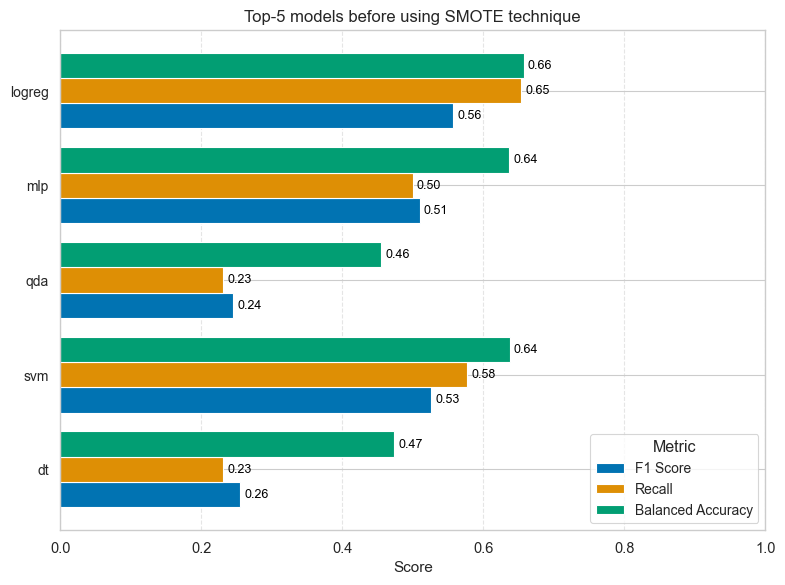

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, f1_score, recall_score, balanced_accuracy_score
)
from sklearn.model_selection import GridSearchCV
cv_boot = StratifiedShuffleSplit(
    n_splits=200,
    test_size=0.25,
    random_state=42
)
# 1) Retrain en train+val y evalúa en test
X_train = pd.concat([X_train, X_val], axis=0)
y_train = pd.concat([y_train, y_val], axis=0)

top_names = (
    results_df[results_df.metric == "f1"]
    .sort_values("mean", ascending=False)
    .head(5)['model']
    .tolist()
)
final_results = []
for name in top_names:
    print(f"🔄 Retraining and tuning {model_names[name]}…")
    gs = GridSearchCV(
        estimator = model_params[name]['model'],
        param_grid = model_params[name]['params'],
        scoring    = scoring,
        refit      = 'f1',
        cv         = cv_boot,
        n_jobs     = -1
    )
    gs.fit(X_train, y_train)
    best = gs.best_estimator_

    y_pred  = best.predict(X_test)


    rec = {
        'Model': name,
        'F1 Score':        f1_score(y_test,          y_pred),
        'Recall':          recall_score(y_test,      y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
    }
    final_results.append(rec)



final_df = pd.DataFrame(final_results)
final_df = final_df[['Model', 'F1 Score', 'Recall', 'Balanced Accuracy']]


results_df_actual=final_df.copy()




# Suponiendo que final_df ya está definido y contiene las métricas
metrics   = ['F1 Score', 'Recall', 'Balanced Accuracy']
n_metrics = len(metrics)
y_pos     = np.arange(len(final_df))
bar_h     = 0.8 / n_metrics

palette = sns.color_palette("colorblind", n_colors=n_metrics)

fig, ax = plt.subplots(figsize=(8, 6))

for i, metric in enumerate(metrics):
    bars = ax.barh(
        y       = y_pos + i*bar_h,
        width   = final_df[metric],
        height  = bar_h,
        label   = metric,
        color   = palette[i]
    )
    # Solo mostrar el valor medio sin desviación
    labels = [f"{mean:.2f}" for mean in final_df[metric]]
    ax.bar_label(
        bars,
        labels=labels,
        padding=3,
        fmt="%s",
        fontsize=9,
        color="black"
    )

# Etiquetas y estilo
ax.set_yticks(y_pos + bar_h*(n_metrics-1)/2)
ax.set_yticklabels(final_df['Model'], fontsize=10)
ax.set_xlim(0, 1)
ax.set_xlabel("Score", fontsize=11)
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.legend(title="Metric", loc='lower right', fontsize=10)
plt.title("Top-5 models before using SMOTE technique", fontsize=12)

plt.tight_layout()
plt.show()



# Oversampling with SMOTE

🔄 Adjusting SMOTE and GridSearch: dt
🔄 Adjusting SMOTE and GridSearch: svm
🔄 Adjusting SMOTE and GridSearch: qda


c:\Users\alfre\Desktop\clase\Elements of Artificial Inteligence\Project-2\student-intervention-ml-pipeline\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\alfre\Desktop\clase\Elements of Artificial Inteligence\Project-2\student-intervention-ml-pipeline\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


🔄 Adjusting SMOTE and GridSearch: mlp


c:\Users\alfre\Desktop\clase\Elements of Artificial Inteligence\Project-2\student-intervention-ml-pipeline\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


🔄 Adjusting SMOTE and GridSearch: logreg


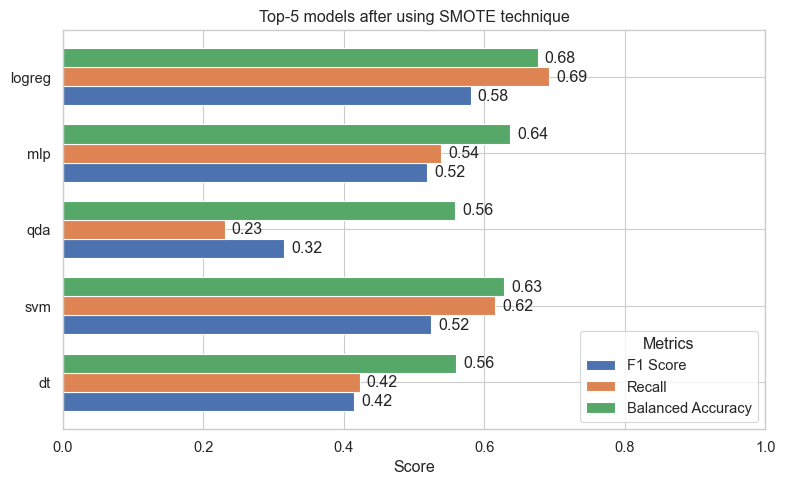

In [138]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

top5 = (
    results_df[results_df.metric=='f1']
    .sort_values('mean', ascending=False)
    .head(5)['model']
    .tolist()
)

smote_results = []
for name in top5:
    print(f"🔄 Adjusting SMOTE and GridSearch: {name}")
    # Pipeline SMOTE + clasificador
    pipe = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', model_params[name]['model'])
    ])
    # Param grid solo para el clasificador
    param_grid = {
        f'clf__{p}': vals
        for p, vals in model_params[name]['params'].items()
    }
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring={'f1':'f1'},
        refit='f1',
        cv=cv_boot,
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    y_pred = best.predict(X_test)

    smote_results.append({
        'Model': name,
        'F1 Score':        f1_score(y_test,          y_pred),
        'Recall':          recall_score(y_test,      y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
    })
smote_df = pd.DataFrame(smote_results).set_index('Model')


metrics = ['F1 Score','Recall','Balanced Accuracy']
n = len(smote_df)
y_pos = np.arange(n)

fig, ax = plt.subplots(figsize=(8,5))
bar_width = 0.25

for i, metric in enumerate(metrics):
    ax.barh(
        y_pos + (i-1)*bar_width,
        smote_df[metric],
        height=bar_width,
        label=metric
    )
    # anotaciones
    for j, val in enumerate(smote_df[metric]):
        ax.text(
            val + 0.01,
            j + (i-1)*bar_width,
            f"{val:.2f}",
            va='center'
        )

ax.set_yticks(y_pos)
ax.set_yticklabels(smote_df.index)
ax.set_xlabel('Score')
ax.set_xlim(0,1)
ax.set_title('Top-5 models after using SMOTE technique')
ax.legend(title='Metrics')
plt.tight_layout()
plt.show()



# Comparision SMOTE vs without SMOTE

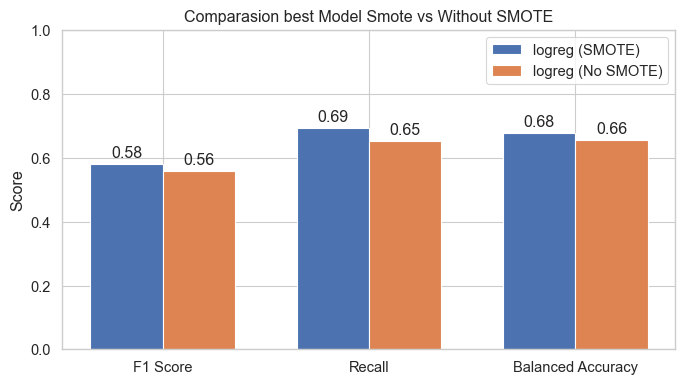

In [139]:

best_smote = smote_df['F1 Score'].idxmax()
scores_smote = smote_df.loc[best_smote, metrics].values

best_nosmote = results_df_actual.set_index('Model')['F1 Score'].idxmax()
nosmote_df = results_df_actual.set_index('Model')
scores_nosmote = nosmote_df.loc[best_nosmote, metrics].values

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(7,4))
ax.bar(x - width/2, scores_smote,  width, label=f'{best_smote} (SMOTE)')
ax.bar(x + width/2, scores_nosmote, width, label=f'{best_nosmote} (No SMOTE)')

# Anotaciones
for i, v in enumerate(scores_smote):
    ax.text(i - width/2, v+0.02, f"{v:.2f}", ha='center')
for i, v in enumerate(scores_nosmote):
    ax.text(i + width/2, v+0.02, f"{v:.2f}", ha='center')

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0,1)
ax.set_ylabel('Score')
ax.set_title('Comparasion best Model Smote vs Without SMOTE')
ax.legend()
plt.tight_layout()
plt.show()

# Conclusion

# References